# Análise de dados

In [1]:
import os
import pandas as pd
import seaborn as sns
from py.functions import (
    plot_confusion_matrix, 
    criar_stream, 
    carregar_e_unificar,
    visualizar_radares_separados_referencia,
    visualizar_assinaturas_barras
)
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, MinMaxScaler
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# relatorio_grupos = analisar_grupos_similares(df_analise, top_features, limiar=0.98)
# display(relatorio_grupos)

# identificar_assinaturas_por_ataque(df_analise, 5, 10000, n_iteracoes=10)

## Processamento 

### Downsample 

In [57]:
def processar_e_salvar_dia(
        dia, 
        dataset_path, 
        chunk_size, 
        cols_to_drop, 
        attack_order, 
        output_files, 
        ATTACK_LABEL_COL,
        BENIGN_LABEL,
        DOWNSAMPLE_FACTORS,
        MIN_SAMPLES_PER_CHUNK
    ):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    LABEL_COL_LIMPA = ATTACK_LABEL_COL.strip() 
    COLS_DROP_LIMPA = [c.strip() for c in cols_to_drop]

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Remove espaços das colunas do DATAFRAME (O que você já fez)
                df_chunk.columns = df_chunk.columns.str.strip()
                
                # Limpeza de Colunas (Usando a lista limpa)
                cols_existentes_drop = [col for col in COLS_DROP_LIMPA if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                if LABEL_COL_LIMPA in df_chunk.columns:
                    df_chunk[LABEL_COL_LIMPA] = df_chunk[LABEL_COL_LIMPA].apply(
                        lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                    )
                else:
                    # Se não achar a coluna Label mesmo após limpar, pula
                    continue
                
                # Usa a variável limpa para filtrar
                df_benign = df_chunk[df_chunk[LABEL_COL_LIMPA] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[LABEL_COL_LIMPA] != BENIGN_LABEL]

                if not df_ataque.empty:
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque = df_ataque.sample(frac=factor, random_state=42)

                # Combina e Restaura a Ordem pelo Índice
                df_chunk_reduzido = pd.concat([df_benign, df_ataque])
                df_chunk_reduzido = df_chunk_reduzido.sort_index()
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'

# Simula o REAL
# DOWNSAMPLE_FACTORS = {
#     'BENIGN': 1.0,           
#     'WebDDoS': 1.0,          
#     'TFTP': 0.0002,          
#     'DrDoS_DNS': 0.001,      
#     'DrDoS_LDAP': 0.001,
#     'DrDoS_MSSQL': 0.001,
#     'DrDoS_NTP': 0.001,
#     'DrDoS_NetBIOS': 0.001,
#     'DrDoS_SNMP': 0.001,
#     'DrDoS_SSDP': 0.001,
#     'DrDoS_UDP': 0.001,
#     'LDAP': 0.001,            
#     'MSSQL': 0.001,
#     'NetBIOS': 0.001,
#     'UDP': 0.001,
#     'Syn': 0.0015,            
#     'UDPLag': 0.005,           
#     'Portmap': 0.01,          
#     'Default': 0.001          
# }

# A Classe Ataques Majoritária
# DOWNSAMPLE_FACTORS = {
#     'WebDDoS': 1.0,          
#     'TFTP': 0.001,           
#     # Reflexão Massiva
#     'DrDoS_DNS': 0.01,       
#     'DrDoS_LDAP': 0.01,
#     'DrDoS_MSSQL': 0.01,
#     'DrDoS_NTP': 0.01,
#     'DrDoS_NetBIOS': 0.01,
#     'DrDoS_SNMP': 0.01,
#     'DrDoS_SSDP': 0.01,
#     'DrDoS_UDP': 0.01,
#     # FAMÍLIA EXPLORAÇÃO/REFLEXÃO 
#     'LDAP': 0.01,            
#     'MSSQL': 0.01,
#     'NetBIOS': 0.01,
#     'UDP': 0.01,
#     # FAMÍLIA TÁTICA 
#     'Syn': 0.05,             
#     'Portmap': 0.1,          
#     'UDPLag': 0.2,           
#     'Default': 0.01          
# }


# A concatenação dos 2 dias fica balanceado (Grande)
DOWNSAMPLE_FACTORS = {
    'WebDDoS': 1.0,          
    'Syn': 0.021,             
    'UDPLag': 0.11,           
    'TFTP': 0.006,           
    'DrDoS_SNMP': 0.022,      
    'DrDoS_DNS': 0.023,       
    'DrDoS_MSSQL': 0.026,     
    'DrDoS_NetBIOS': 0.029,   
    'DrDoS_UDP': 0.037,       
    'DrDoS_SSDP': 0.045,      
    'DrDoS_LDAP': 0.053,      
    'DrDoS_NTP': 0.095,       
    'MSSQL': 0.021,           
    'NetBIOS': 0.034,         
    'UDP': 0.031,             
    'LDAP': 0.055,            
    'Portmap': 0.65,          
    'Default': 0.02           
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11.csv',
    '01-12': 'CICDDoS2019_01_12.csv'
}

dia_0311 = processar_e_salvar_dia(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

dia_0112 = processar_e_salvar_dia(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

Dataset salvo: CICDDoS2019_03_11.csv (Total: 819,585 amostras)
Dataset salvo: CICDDoS2019_01_12.csv (Total: 1,180,678 amostras)


### Verificação da Base de dados gerada

Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64


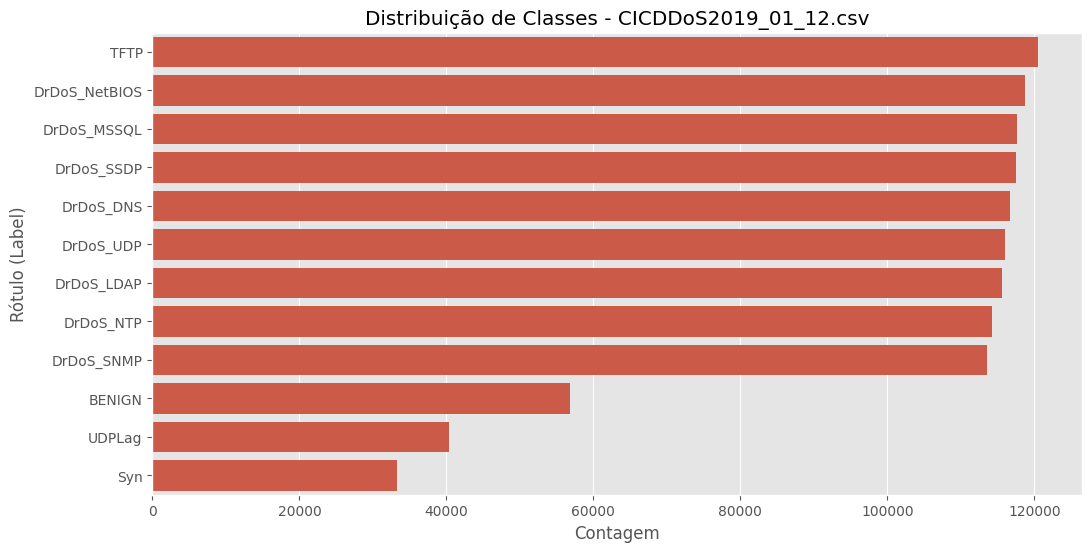

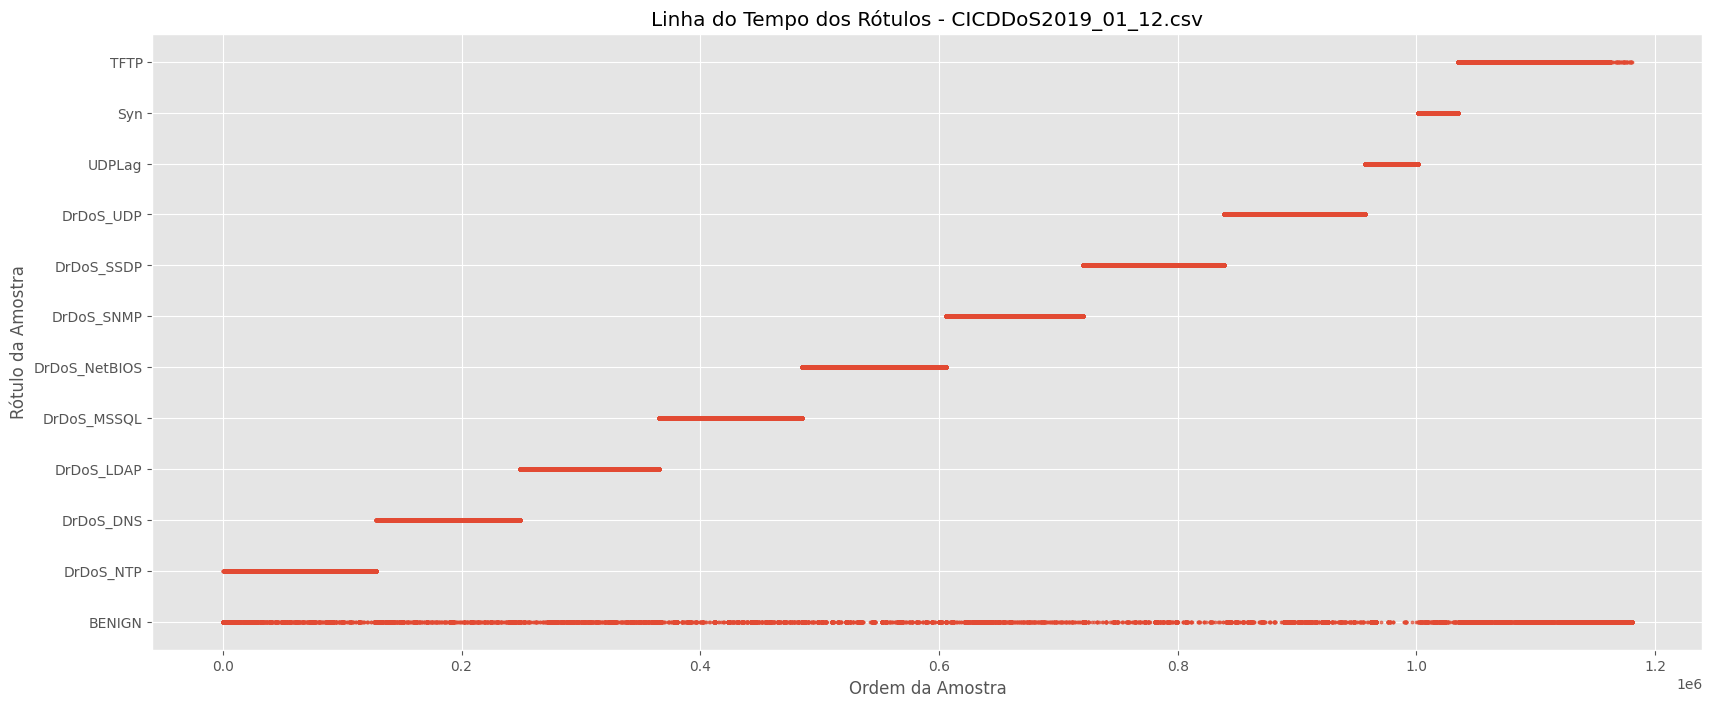

In [71]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
# file = 'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
file = 'CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()

# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()

## Análise dos Ataques

![Ataques](datasets/CICDDoS2019/img/ataques.png)

### DEVELOP CICDDoS2019

In [2]:
ARQUIVOS_ALVO = [
    'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv',  
    'datasets\CICDDoS2019\data\CICDDoS2019_03_11_balanceado.csv'     
]

df = carregar_e_unificar(ARQUIVOS_ALVO, 100000)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 2000263 linhas.


Label
Syn              123215
Portmap          121524
MSSQL            121234
TFTP             120511
UDPLag           119680
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
NetBIOS          117459
UDP              117152
DrDoS_DNS        116641
DrDoS_UDP        115985
LDAP             115946
DrDoS_LDAP       115536
DrDoS_NTP        114251
BENIGN           113828
DrDoS_SNMP       113522
Name: count, dtype: int64

In [3]:
print("1. Preparação dos Dados")

TAMANHO_AMOSTRA = 100000

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df['Label'].unique())

df_amostra = df.groupby('Label').apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=['Label'])
y = df_amostra['Label']

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = MinMaxScaler() 
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


Label
BENIGN           5882
DrDoS_DNS        5882
DrDoS_LDAP       5882
DrDoS_MSSQL      5882
DrDoS_NTP        5882
DrDoS_NetBIOS    5882
DrDoS_SNMP       5882
DrDoS_SSDP       5882
DrDoS_UDP        5882
LDAP             5882
MSSQL            5882
NetBIOS          5882
Portmap          5882
Syn              5882
TFTP             5882
UDP              5882
UDPLag           5882
Name: count, dtype: int64

In [4]:
print("2. Seleção de Features e Extração de DNA Comportamental")

rf_sel = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)

# O X_trans agora já está entre 0 e 1 (correto)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] 
feature_names_final = X_numeric.columns[indices_top]

print(f"Features Selecionadas: {list(feature_names_final)}")

print(" > Calculando perfil típico de cada ataque...")

# Filtramos o dataset original (já normalizado Globalmente)
X_top_features = pd.DataFrame(X_trans, columns=X_numeric.columns).iloc[:, indices_top]
X_top_features['Label'] = y.values

# Calculamos a MEDIANA. 
df_final_sig = X_top_features.groupby('Label').median()

print(" > Matriz de Assinaturas (Comportamental) Gerada!")
display(df_final_sig)

2. Seleção de Features e Extração de DNA Comportamental
Features Selecionadas: ['Flow IAT Mean', 'Flow Packets/s', 'Flow Duration', 'Fwd IAT Total', 'act_data_pkt_fwd', 'Flow IAT Std', 'min_seg_size_forward', 'ACK Flag Count', 'Init_Win_bytes_forward', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Fwd Packet Length Min', 'Min Packet Length', 'Packet Length Mean', 'Average Packet Size', 'Fwd Packet Length Mean', 'Max Packet Length', 'Avg Fwd Segment Size', 'Fwd Packet Length Max']
 > Calculando perfil típico de cada ataque...
 > Matriz de Assinaturas (Comportamental) Gerada!


,Flow IAT Mean,Flow Packets/s,Flow Duration,Fwd IAT Total,act_data_pkt_fwd,Flow IAT Std,min_seg_size_forward,ACK Flag Count,Init_Win_bytes_forward,Flow Bytes/s,Total Length of Fwd Packets,Subflow Fwd Bytes,Fwd Packet Length Min,Min Packet Length,Packet Length Mean,Average Packet Size,Fwd Packet Length Mean,Max Packet Length,Avg Fwd Segment Size,Fwd Packet Length Max
Label,,,,,,,,,,,,,,,,,,,,
BENIGN,1.413435e-04,4.793191e-05,1.742543e-04,2.500005e-08,0.001984,0.000270,0.999999,0.0,0.003891,2.174388e-06,0.000483,0.000483,0.000492,0.000000,0.010508,0.013127,0.014265,0.001370,0.014265,0.008633
DrDoS_DNS,2.034500e-08,5.000000e-01,8.333342e-09,8.333350e-09,0.001984,0.000000,0.999999,0.0,0.000000,9.945652e-01,0.022950,0.022950,0.724053,1.000000,0.457641,0.686006,0.724053,0.043836,0.724053,0.409914
DrDoS_LDAP,2.034500e-08,5.000000e-01,8.333342e-09,8.333350e-09,0.001984,0.000000,0.999999,0.0,0.000000,1.000000e+00,0.022950,0.022950,0.724053,1.000000,0.457641,0.686006,0.724053,0.043836,0.724053,0.409914
DrDoS_MSSQL,2.034500e-08,5.000000e-01,8.333342e-09,8.333350e-09,0.001984,0.000000,0.999999,0.0,0.000000,3.104620e-01,0.007577,0.007577,0.239056,0.330163,0.151096,0.226494,0.239056,0.014473,0.239056,0.135338
DrDoS_NTP,4.896613e-07,1.084927e-02,8.308342e-06,8.308350e-06,0.077381,0.000001,0.999999,0.0,0.000000,6.278315e-03,0.136077,0.136077,0.216429,0.298913,0.136795,0.137970,0.216429,0.013103,0.216429,0.122529
DrDoS_NetBIOS,2.034500e-08,5.000000e-01,8.333342e-09,8.333350e-09,0.001984,0.000000,0.999999,0.0,0.000000,1.555707e-01,0.003570,0.003570,0.112641,0.155571,0.071195,0.106722,0.112641,0.006820,0.112641,0.063771
DrDoS_SNMP,4.069000e-08,2.500000e-01,1.666668e-08,1.666670e-08,0.001984,0.000000,0.999999,0.0,0.000000,5.000000e-01,0.022950,0.022950,0.724053,1.000000,0.457641,0.686006,0.724053,0.043836,0.724053,0.409914
DrDoS_SSDP,9.765601e-07,1.041666e-02,4.083338e-07,4.083341e-07,0.001984,0.000000,0.999999,0.0,0.000000,5.420328e-03,0.010337,0.010337,0.184456,0.254755,0.116586,0.174764,0.184456,0.011584,0.184456,0.108326
DrDoS_UDP,2.572286e-06,2.504369e-03,4.195838e-06,4.195842e-06,0.005952,0.000005,0.999999,0.0,0.000000,1.417211e-03,0.010898,0.010898,0.178554,0.246603,0.114597,0.153792,0.181505,0.011584,0.181505,0.108326


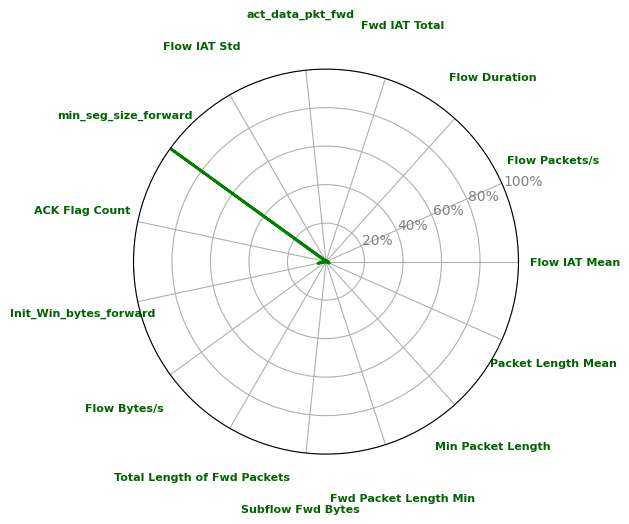

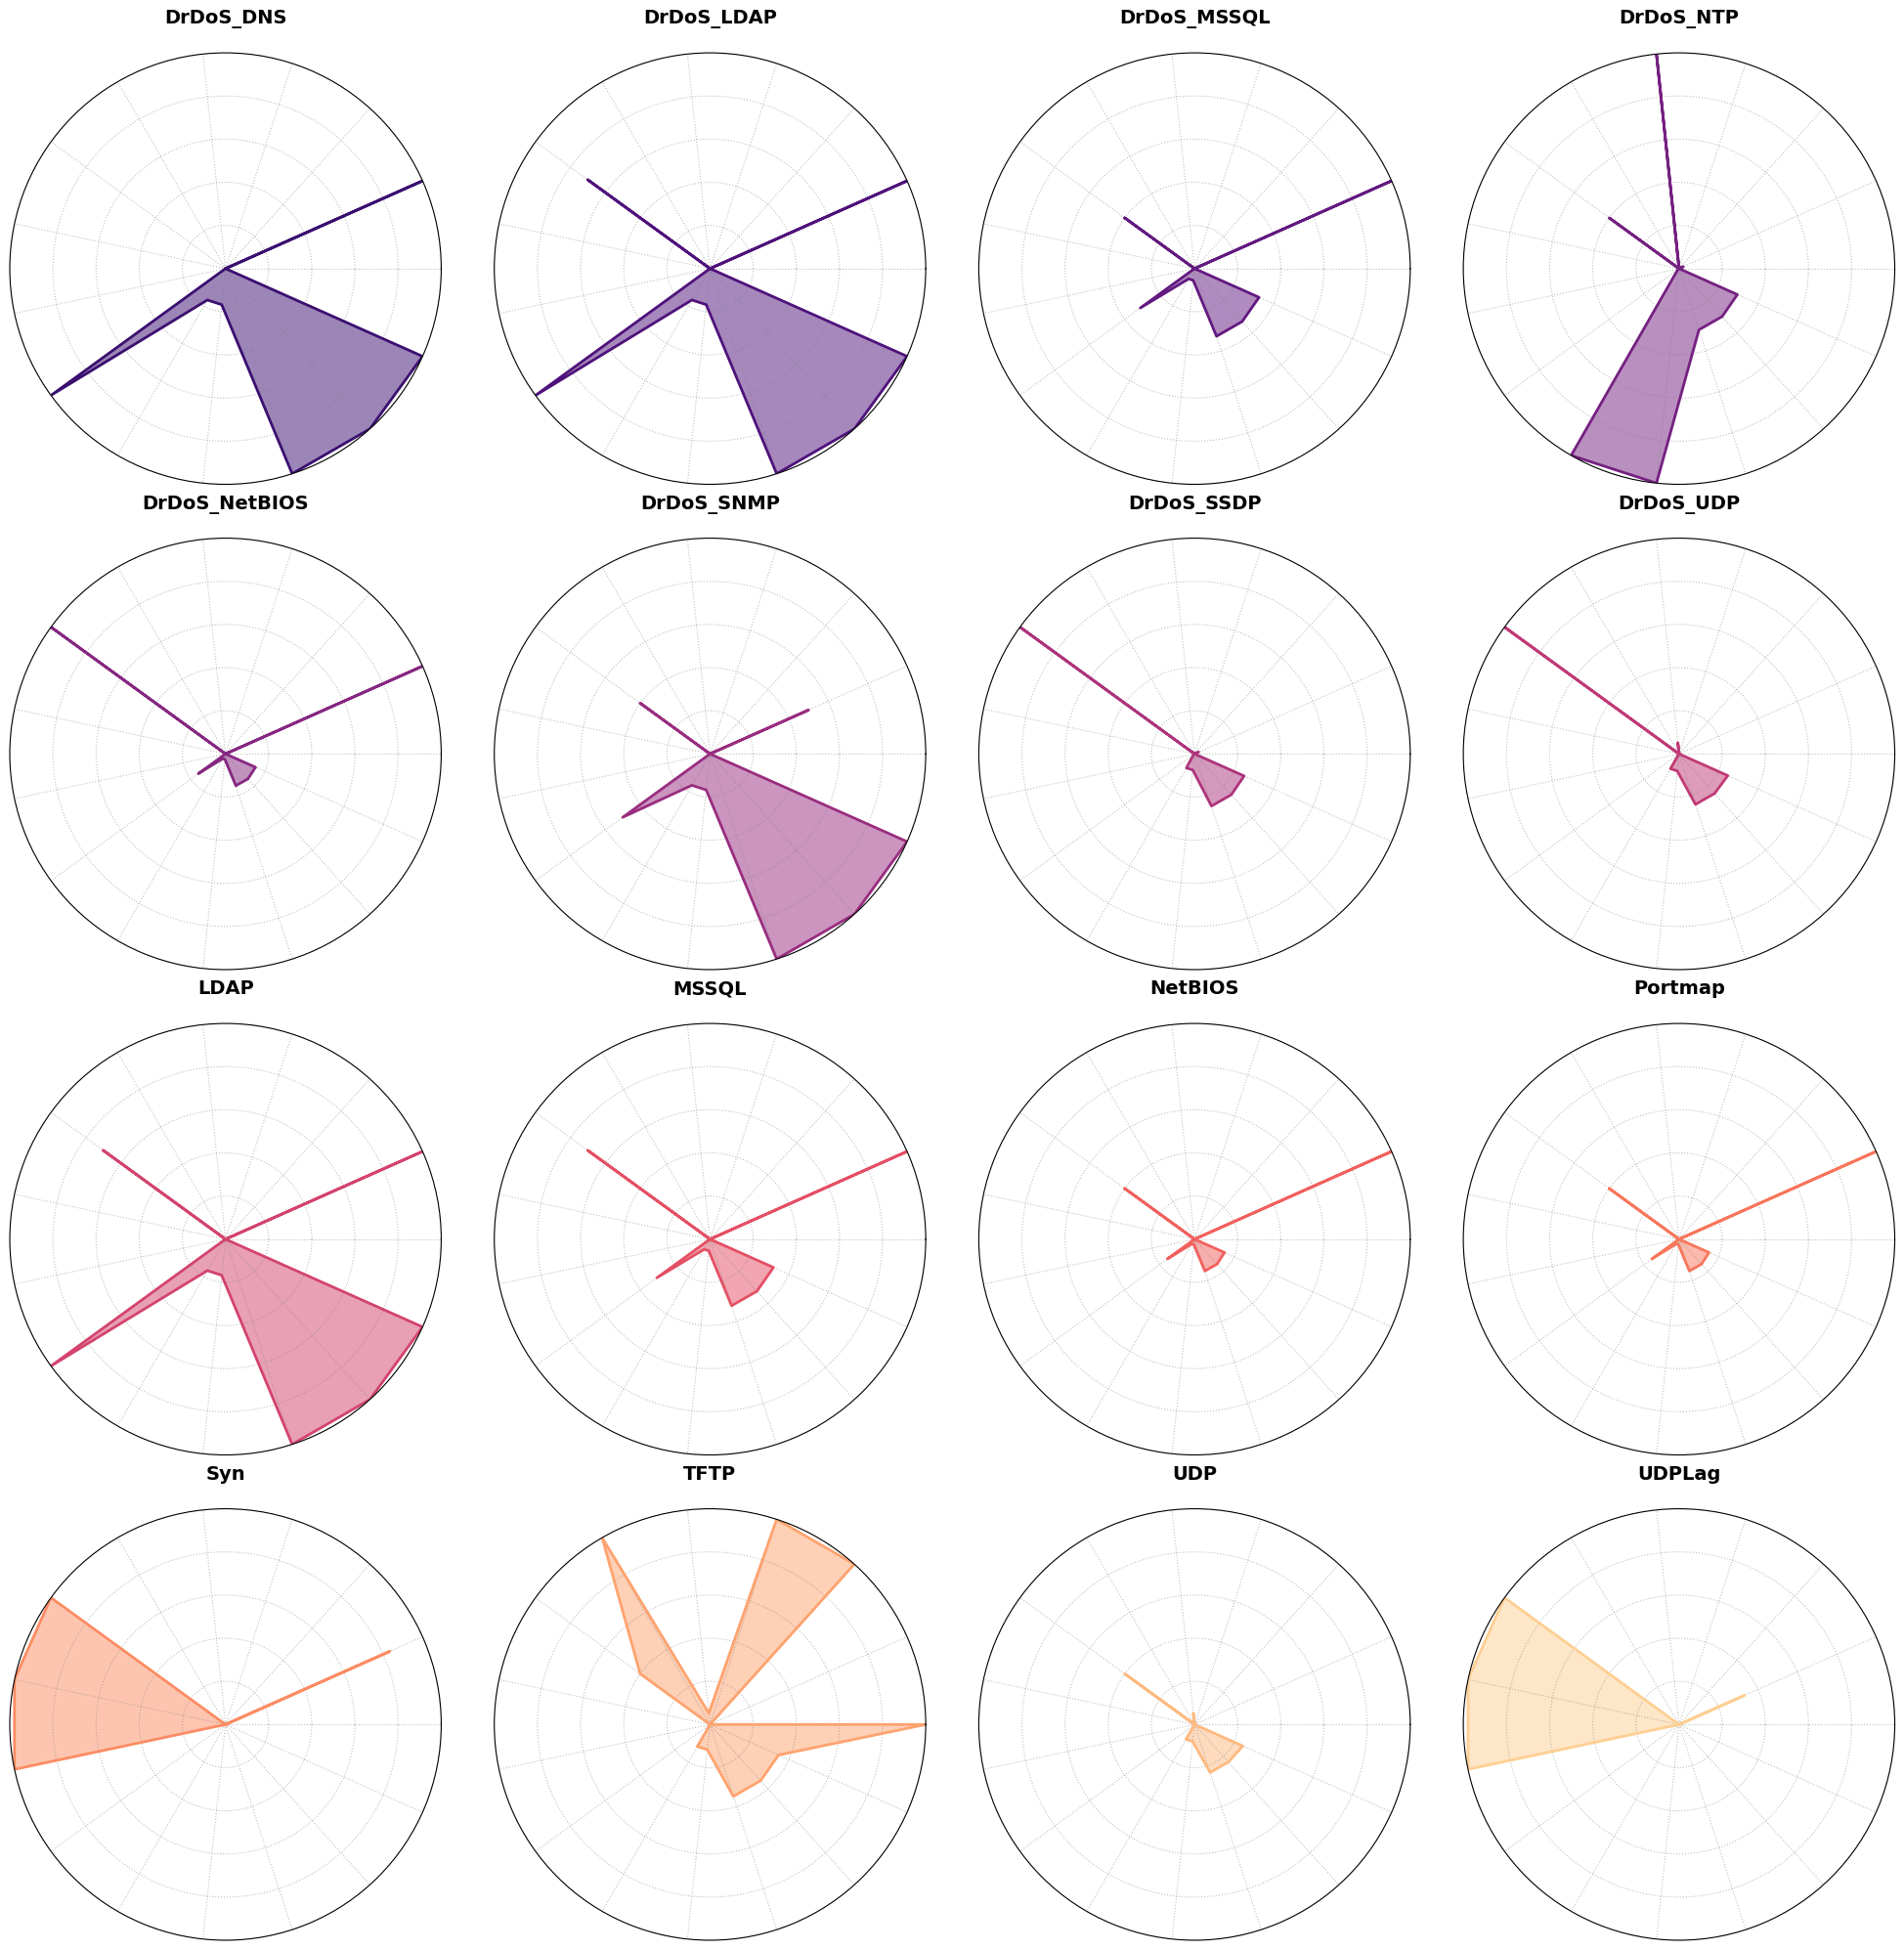

In [6]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares_separados_referencia(df_radar_ready, features_para_plotar)

Corte utilizado: 0.77
Métrica: MANHATTAN
Ligação: AVERAGE


,Qtd,Ataques,Manhattan,Assinatura
0,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.3759,"Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean"
1,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.4297,"min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,"DrDoS_NetBIOS, NetBIOS, Portmap",0.0000,"min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min"
3,2,"DrDoS_MSSQL, MSSQL",0.0316,"min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min"
4,2,"Syn, UDPLag",0.2500,"ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
5,1,BENIGN,Único,"min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean"


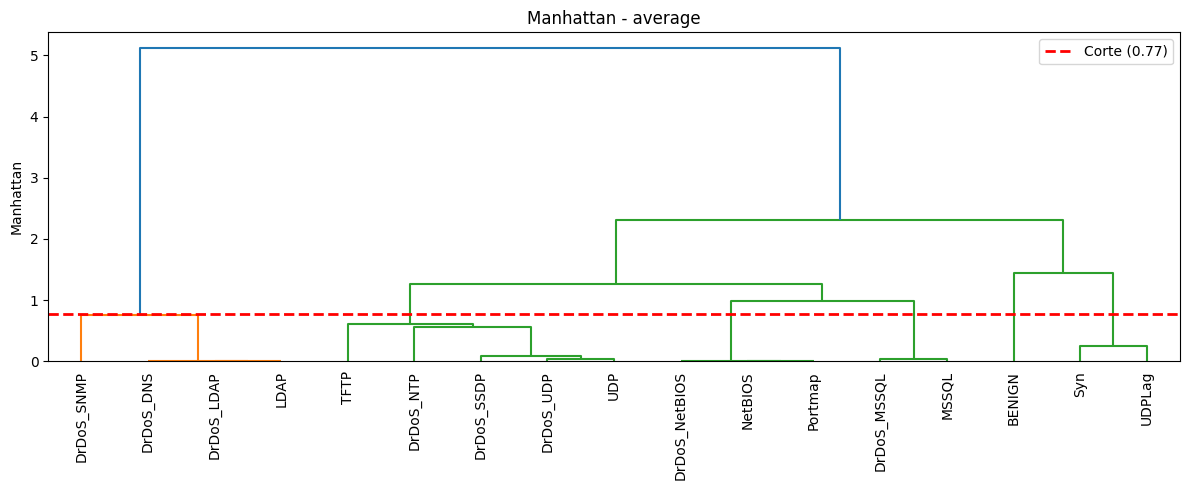

Corte utilizado: 1.08
Métrica: MANHATTAN
Ligação: COMPLETE


,Qtd,Ataques,Manhattan,Assinatura
0,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.3759,"Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean"
1,2,"Syn, UDPLag",0.2500,"ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
2,1,BENIGN,Único,"min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean"
3,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.4297,"min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
4,5,"DrDoS_MSSQL, DrDoS_NetBIOS, MSSQL, NetBIOS, Portmap",0.5911,"min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min"


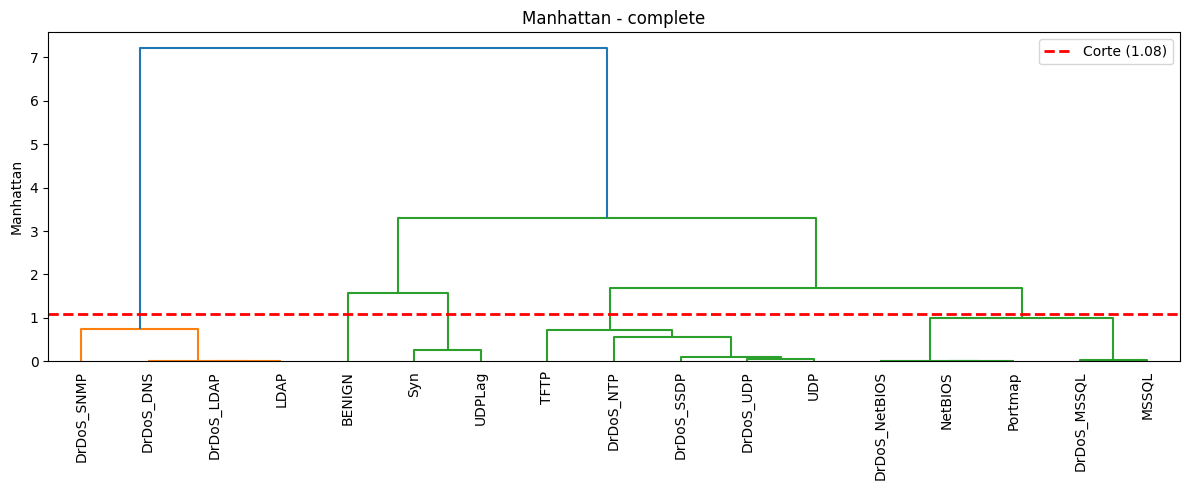

Corte utilizado: 0.80
Métrica: MANHATTAN
Ligação: MEDIAN


,Qtd,Ataques,Manhattan,Assinatura
0,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.3759,"Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean"
1,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.4297,"min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,"DrDoS_NetBIOS, NetBIOS, Portmap",0.0000,"min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min"
3,2,"DrDoS_MSSQL, MSSQL",0.0316,"min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min"
4,2,"Syn, UDPLag",0.2500,"ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
5,1,BENIGN,Único,"min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean"


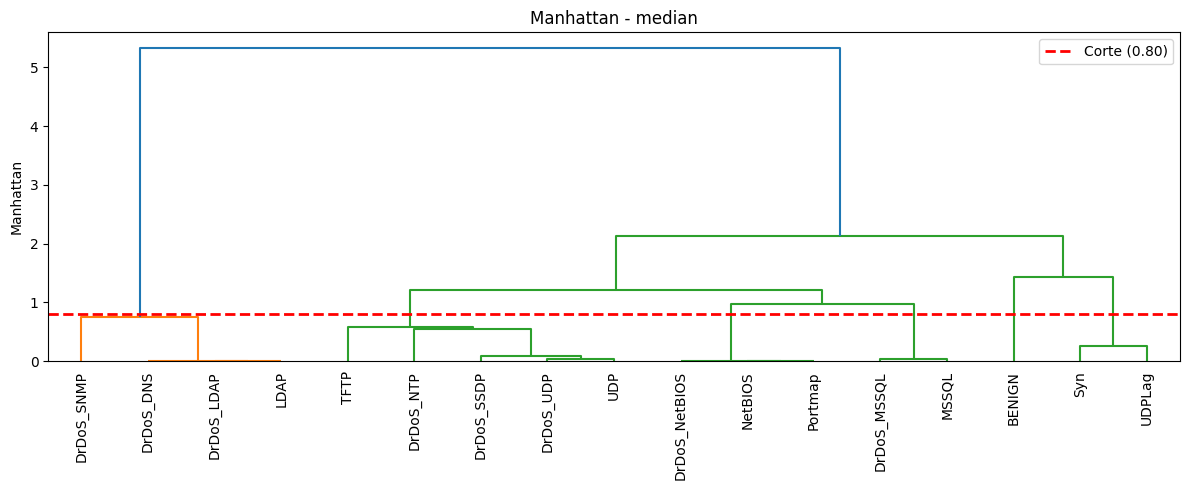

Corte utilizado: 0.27
Métrica: EUCLIDIANA
Ligação: AVERAGE


,Qtd,Ataques,Euclidiana,Assinatura
0,3,"DrDoS_DNS, DrDoS_LDAP, LDAP",0.0036,"Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean"
1,1,DrDoS_SNMP,Único,"Min Packet Length, min_seg_size_forward, Fwd Packet Length Min, Fwd Packet Length Mean, Avg Fwd Segment Size"
2,2,"Syn, UDPLag",0.2500,"ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
3,3,"DrDoS_NetBIOS, NetBIOS, Portmap",0.0000,"min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min"
4,2,"DrDoS_MSSQL, MSSQL",0.0114,"min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min"
5,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.1510,"min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
6,1,BENIGN,Único,"min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean"


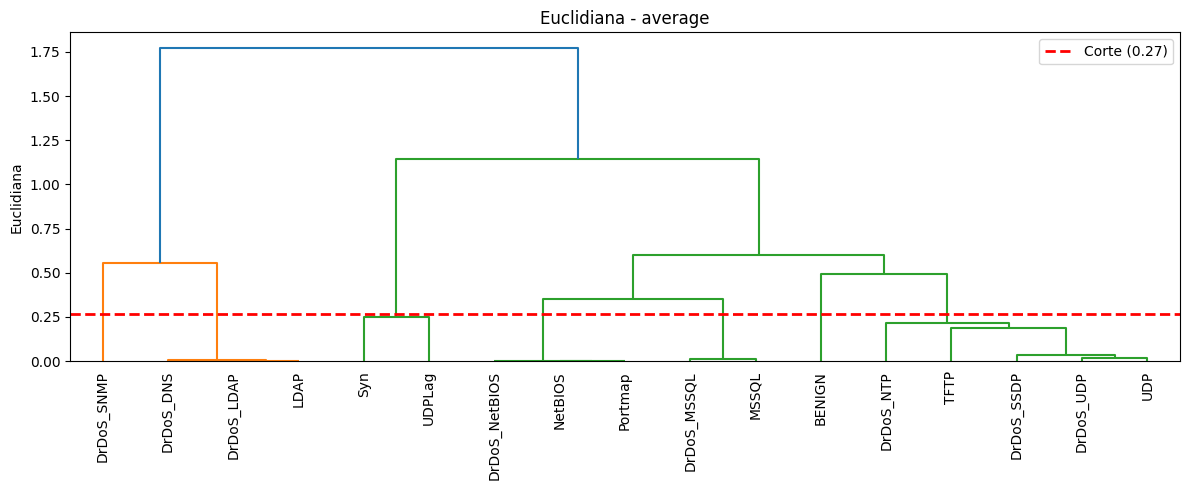

Corte utilizado: 0.35
Métrica: EUCLIDIANA
Ligação: COMPLETE


,Qtd,Ataques,Euclidiana,Assinatura
0,3,"DrDoS_DNS, DrDoS_LDAP, LDAP",0.0036,"Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean"
1,1,DrDoS_SNMP,Único,"Min Packet Length, min_seg_size_forward, Fwd Packet Length Min, Fwd Packet Length Mean, Avg Fwd Segment Size"
2,2,"Syn, UDPLag",0.2500,"ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
3,3,"DrDoS_NetBIOS, NetBIOS, Portmap",0.0000,"min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min"
4,2,"DrDoS_MSSQL, MSSQL",0.0114,"min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min"
5,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.1510,"min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
6,1,BENIGN,Único,"min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean"


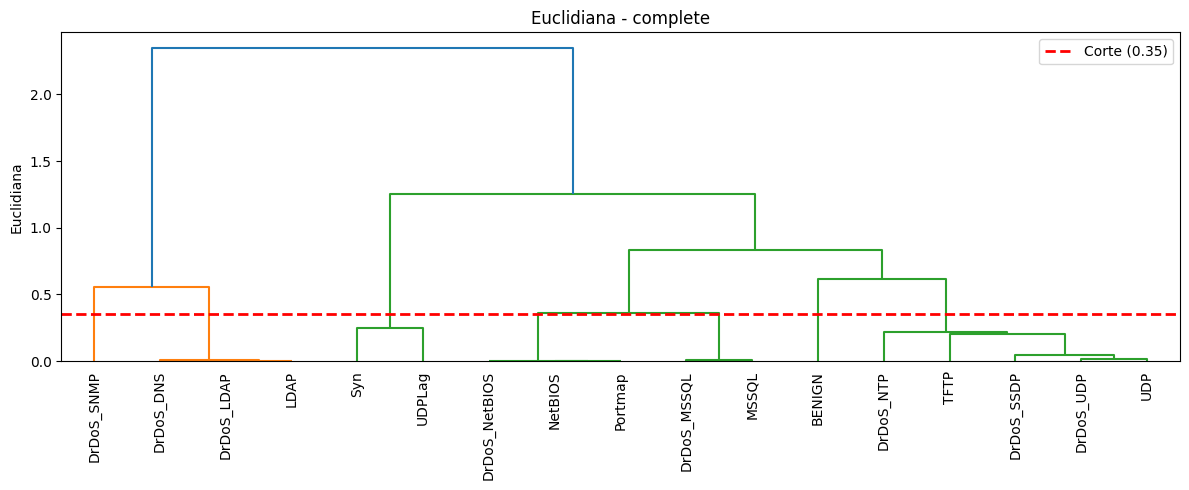

Corte utilizado: 0.28
Métrica: EUCLIDIANA
Ligação: MEDIAN


,Qtd,Ataques,Euclidiana,Assinatura
0,3,"DrDoS_DNS, DrDoS_LDAP, LDAP",0.0036,"Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean"
1,1,DrDoS_SNMP,Único,"Min Packet Length, min_seg_size_forward, Fwd Packet Length Min, Fwd Packet Length Mean, Avg Fwd Segment Size"
2,2,"Syn, UDPLag",0.2500,"ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
3,3,"DrDoS_NetBIOS, NetBIOS, Portmap",0.0000,"min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min"
4,2,"DrDoS_MSSQL, MSSQL",0.0114,"min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min"
5,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.1510,"min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
6,1,BENIGN,Único,"min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean"


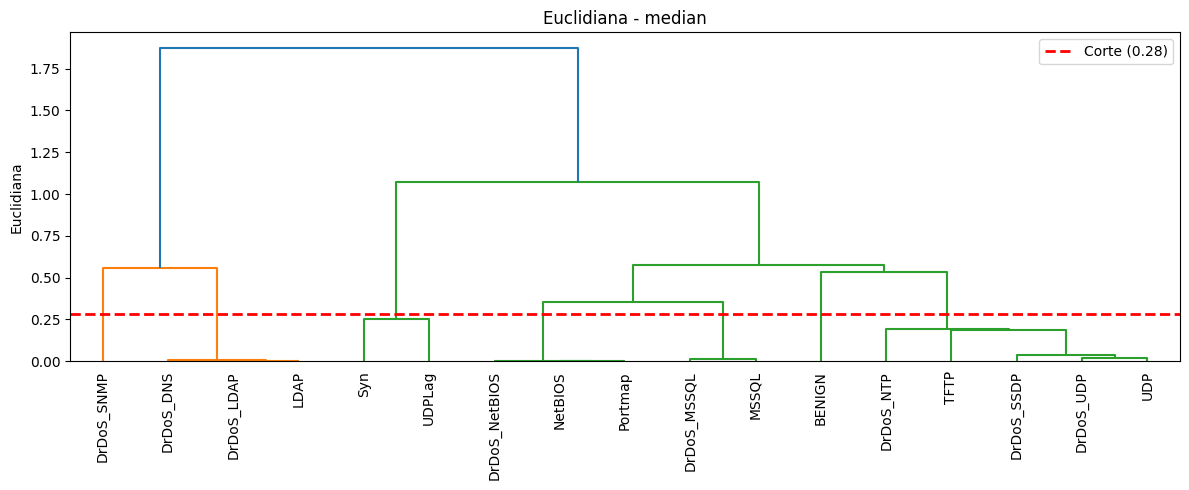

In [12]:
config_metricas = [
    ('Manhattan', 'cityblock'),
    ('Euclidiana', 'euclidean'),
]

config_linkage = ['average', 'complete', 'median']

for nome_metrica, str_metrica in config_metricas:
    # Calcula a matriz de distância condensada nativa
    dist_condensada_atual = pdist(df_final_sig, metric=str_metrica)
    
    # Converte para matriz quadrada para podermos calcular a média interna do grupo depois
    matriz_distancia_full = squareform(dist_condensada_atual)

    for metodo_link in config_linkage:
        # Hierarquia
        Z = linkage(dist_condensada_atual, method=metodo_link)

        # Definição do Corte 
        corte = 0.15 * max(Z[:, 2])
        lbl_corte = f"{corte:.2f}"
        tipo_medida = f"{nome_metrica}"

        # Clusterização
        final_labels = fcluster(Z, t=corte, criterion='distance')

        # Relatório 
        report = []
        for cid in sorted(set(final_labels)):
            membros = df_final_sig.index[final_labels == cid].tolist()
            indices_membros = np.where(final_labels == cid)[0]
            
            if len(membros) > 1:
                # Se tem grupo, calcula a média real
                sub_matriz = matriz_distancia_full[np.ix_(indices_membros, indices_membros)]
                valores_distancia = sub_matriz[np.triu_indices(len(membros), k=1)]
                media_distancia = valores_distancia.mean()
                
                # Formata o valor
                if str_metrica == 'cosine':
                    val_display = 1 - media_distancia # Converte dist volta para similaridade
                    val_str = f"{val_display:.4f}"
                else:
                    val_str = f"{media_distancia:.4f}"
            else:
                # Se for item único, não calculamos média (para não dar 1.0 ou 0.0 enganoso)
                val_str = "Único"

            # Assinatura
            avg_imp = df_final_sig.loc[membros].mean()
            top_feats = avg_imp.nlargest(5).index.tolist()
            
            report.append({
                'Qtd': len(membros),
                'Ataques': ", ".join(membros),
                f'{tipo_medida}': val_str,
                'Assinatura': ", ".join(top_feats)
            })
        
        # Exibir Tabela
        print(f"Corte utilizado: {lbl_corte}")
        print(f"Métrica: {nome_metrica.upper()}")
        print(f"Ligação: {metodo_link.upper()}")
        display(pd.DataFrame(report))

        # Plotar Dendrograma
        plt.figure(figsize=(12, 5))
        dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
        plt.axhline(y=corte, c='r', ls='--', lw=2, label=f'Corte ({corte:.2f})')
        plt.title(f"{nome_metrica} - {metodo_link}")
        plt.ylabel(f"{tipo_medida}")
        plt.legend()
        plt.tight_layout()
        plt.show()

### DEVELOP CIC-IDS-2017

In [22]:
ARQUIVOS_ALVO = [
    'datasets\CIC-IDS-2017\Wednesday-workingHours.pcap_ISCX.csv',  
    'datasets\CIC-IDS-2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'     
]

df = carregar_e_unificar(ARQUIVOS_ALVO, 100000)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 918448 linhas.


Label
BENIGN              537749
DoS Hulk            231073
DDoS                128027
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64

In [23]:
print("1. Preparação dos Dados")

TAMANHO_AMOSTRA = 40000

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df['Label'].unique())

df = df[df['Label'] != 'Heartbleed']

df_amostra = df.groupby('Label').apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=['Label'])
y = df_amostra['Label']

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = MinMaxScaler() 
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


Label
BENIGN              5714
DDoS                5714
DoS GoldenEye       5714
DoS Hulk            5714
DoS slowloris       5714
DoS Slowhttptest    5499
Name: count, dtype: int64

In [24]:
print("2. Seleção de Features e Extração de DNA Comportamental")

rf_sel = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)

# O X_trans agora já está entre 0 e 1 (correto)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] 
feature_names_final = X_numeric.columns[indices_top]

print(f"Features Selecionadas: {list(feature_names_final)}")

print(" > Calculando perfil típico de cada ataque...")

# Filtramos o dataset original (já normalizado Globalmente)
X_top_features = pd.DataFrame(X_trans, columns=X_numeric.columns).iloc[:, indices_top]
X_top_features['Label'] = y.values

# Calculamos a MEDIANA. 
df_final_sig = X_top_features.groupby('Label').median()

print(" > Matriz de Assinaturas (Comportamental) Gerada!")
display(df_final_sig)

2. Seleção de Features e Extração de DNA Comportamental
Features Selecionadas: ['Bwd Packet Length Max', 'Subflow Bwd Bytes', 'Fwd Packet Length Mean', 'Fwd IAT Mean', 'Flow Packets/s', 'Bwd Header Length', 'Packet Length Mean', 'Flow IAT Std', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Max Packet Length', 'Active Min', 'Flow IAT Mean', 'Total Length of Bwd Packets', 'Bwd Packet Length Std', 'Avg Bwd Segment Size', 'Fwd Packet Length Max', 'Init_Win_bytes_forward', 'min_seg_size_forward']
 > Calculando perfil típico de cada ataque...
 > Matriz de Assinaturas (Comportamental) Gerada!


,Bwd Packet Length Max,Subflow Bwd Bytes,Fwd Packet Length Mean,Fwd IAT Mean,Flow Packets/s,Bwd Header Length,Packet Length Mean,Flow IAT Std,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd Packet Length Mean,Max Packet Length,Active Min,Flow IAT Mean,Total Length of Bwd Packets,Bwd Packet Length Std,Avg Bwd Segment Size,Fwd Packet Length Max,Init_Win_bytes_forward,min_seg_size_forward
Label,,,,,,,,,,,,,,,,,,,,
BENIGN,0.007050,0.000048,0.013291,3.333333e-08,2.849237e-05,0.000864,0.028250,0.000003,0.000256,0.000256,0.019601,0.008425,0.000000e+00,0.000134,0.000048,0.000000,0.019601,0.003536,0.001953,0.357143
DDoS,0.376547,0.004190,0.002412,4.224943e-03,8.251223e-07,0.001987,0.383700,0.011993,0.000095,0.000095,0.498925,0.376547,0.000000e+00,0.004225,0.004190,0.326066,0.498925,0.001725,0.003922,0.357143
DoS GoldenEye,0.373453,0.004201,0.018166,9.609017e-03,3.192987e-07,0.003628,0.257832,0.025130,0.001382,0.001382,0.375000,0.373453,5.467153e-05,0.009470,0.004201,0.262443,0.375000,0.031997,0.445572,0.571429
DoS Hulk,0.373453,0.004188,0.015812,1.025000e-01,4.875918e-08,0.004319,0.366652,0.290598,0.001214,0.001214,0.427208,0.373453,4.379562e-07,0.055009,0.004188,0.262160,0.427208,0.027943,0.003845,0.571429
DoS Slowhttptest,0.000000,0.000000,0.000000,8.750000e-02,3.139850e-08,0.000000,0.000000,0.145299,0.000000,0.000000,0.000000,0.000000,5.112655e-01,0.087500,0.000000,0.000000,0.000000,0.000000,0.445572,0.714286
DoS slowloris,0.000000,0.000000,0.002757,5.869524e-02,5.437660e-08,0.001382,0.002332,0.152625,0.000059,0.000059,0.000000,0.000688,3.211679e-06,0.048910,0.000000,0.000000,0.000000,0.000690,0.445572,0.571429


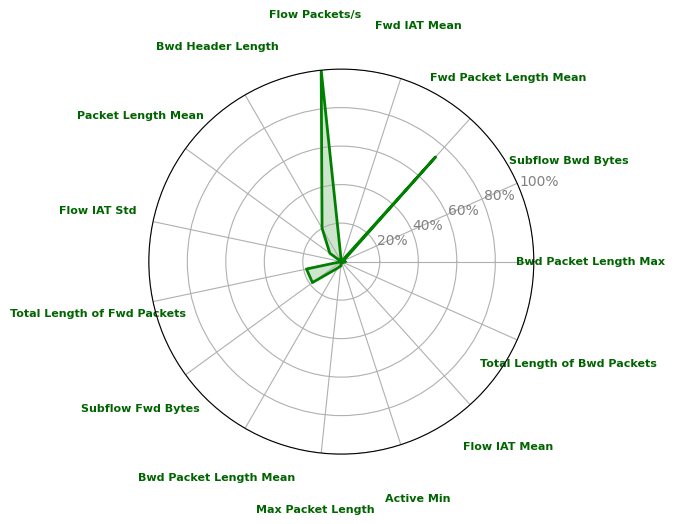

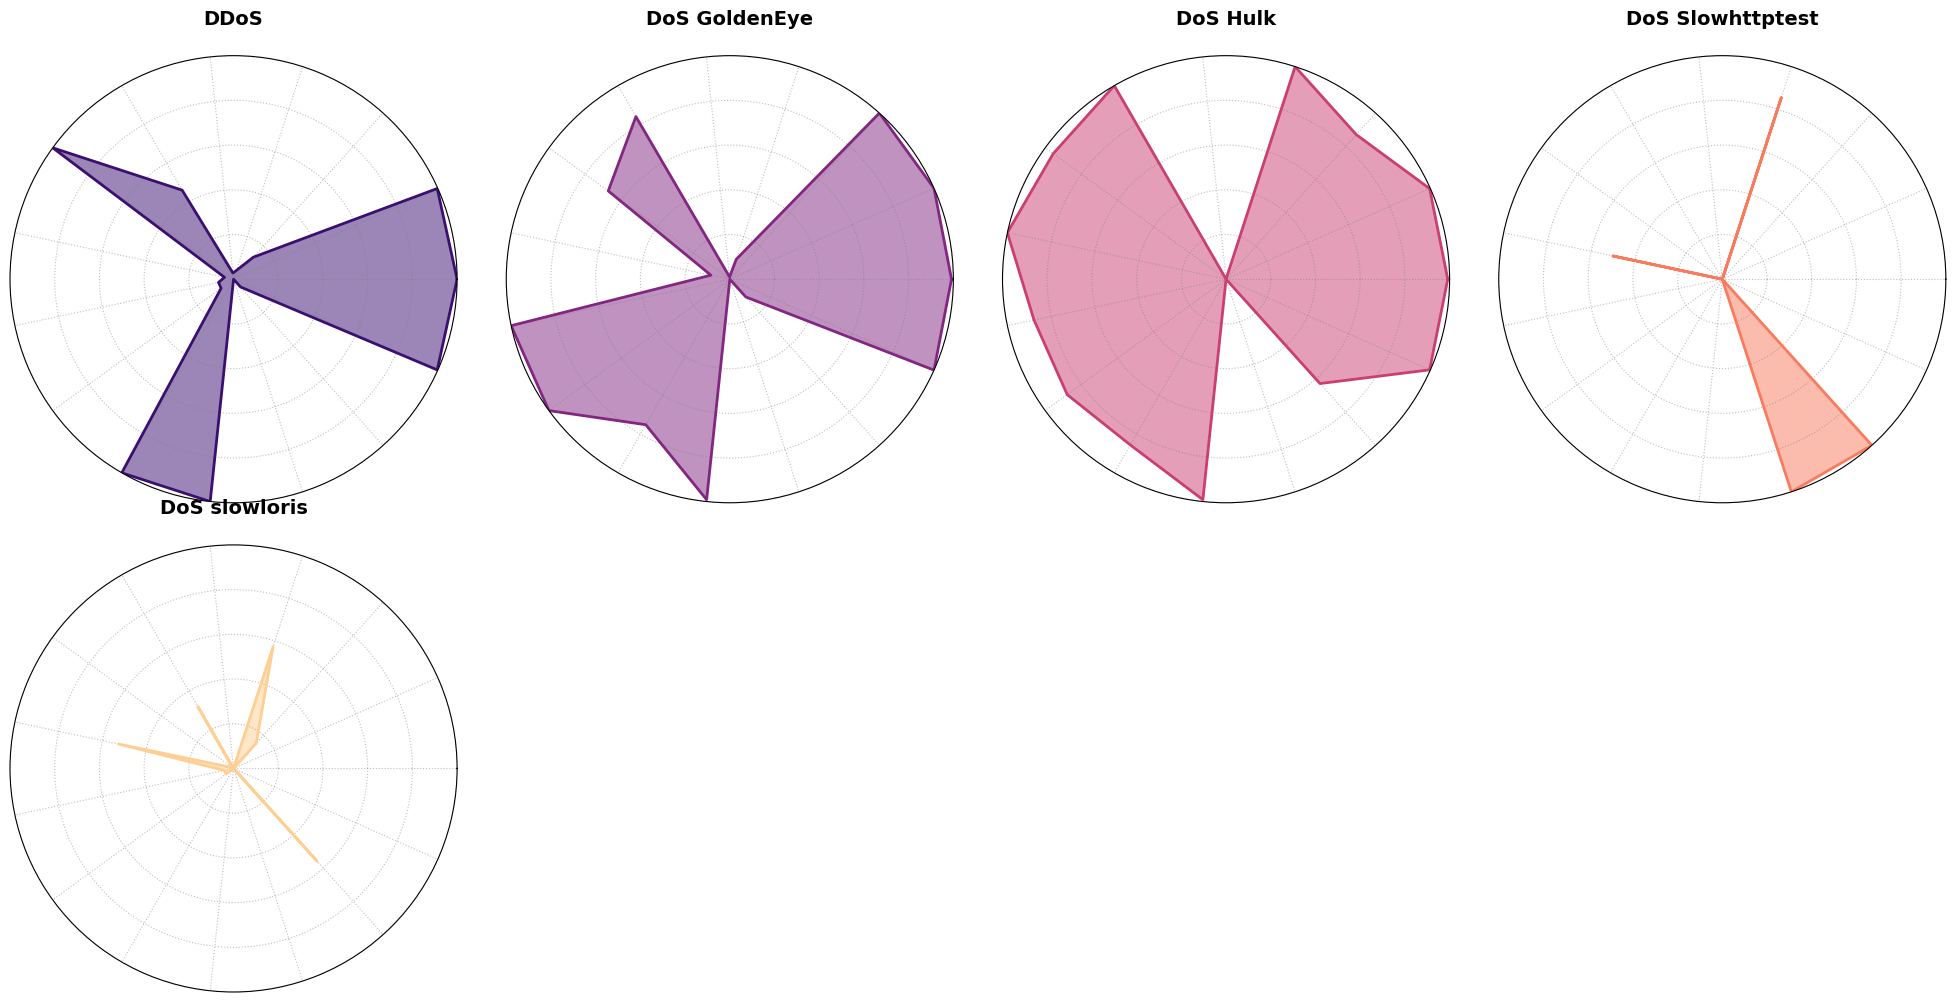

In [35]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares_separados_referencia(df_radar_ready, features_para_plotar)

Corte utilizado: 1.21
Métrica: MANHATTAN
Ligação: AVERAGE


,Qtd,Ataques,Manhattan,Assinatura
0,3,"DDoS, DoS GoldenEye, DoS Hulk",1.0523,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
1,2,"DoS Slowhttptest, DoS slowloris",0.7368,"min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean"
2,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


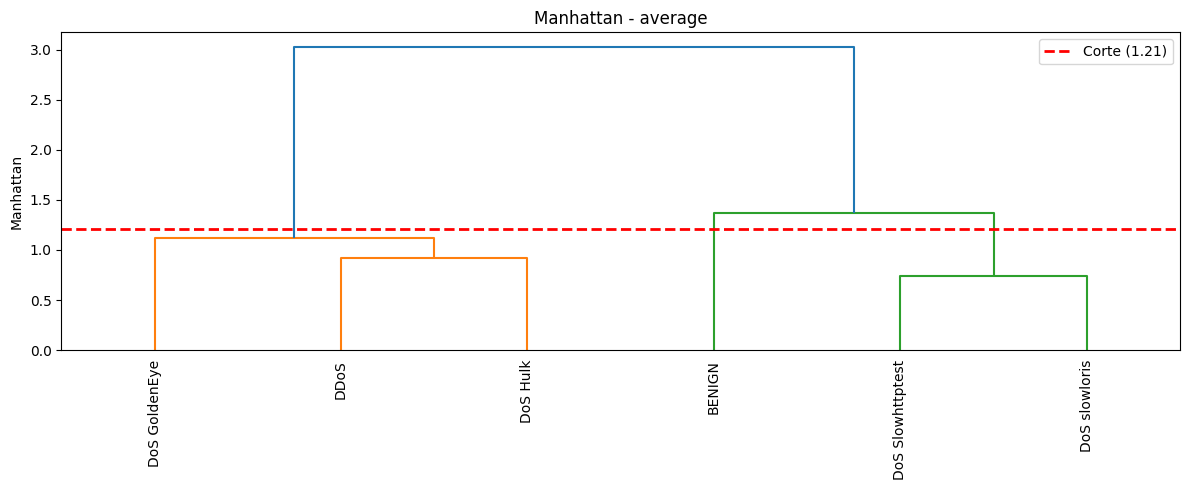

Corte utilizado: 1.63
Métrica: MANHATTAN
Ligação: COMPLETE


,Qtd,Ataques,Manhattan,Assinatura
0,3,"DDoS, DoS GoldenEye, DoS Hulk",1.0523,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
1,2,"DoS Slowhttptest, DoS slowloris",0.7368,"min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean"
2,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


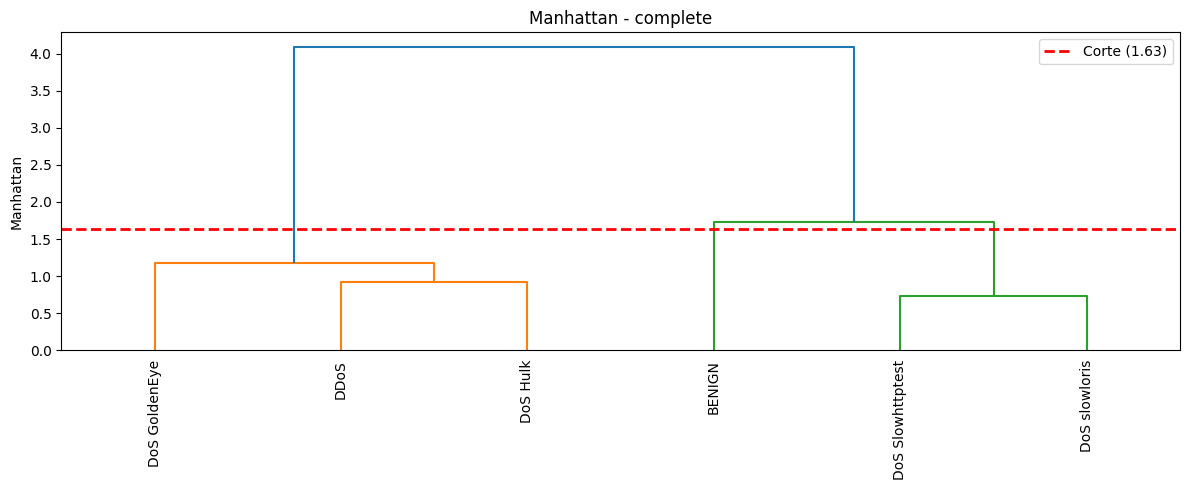

Corte utilizado: 1.10
Métrica: MANHATTAN
Ligação: MEDIAN


,Qtd,Ataques,Manhattan,Assinatura
0,3,"DDoS, DoS GoldenEye, DoS Hulk",1.0523,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
1,2,"DoS Slowhttptest, DoS slowloris",0.7368,"min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean"
2,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


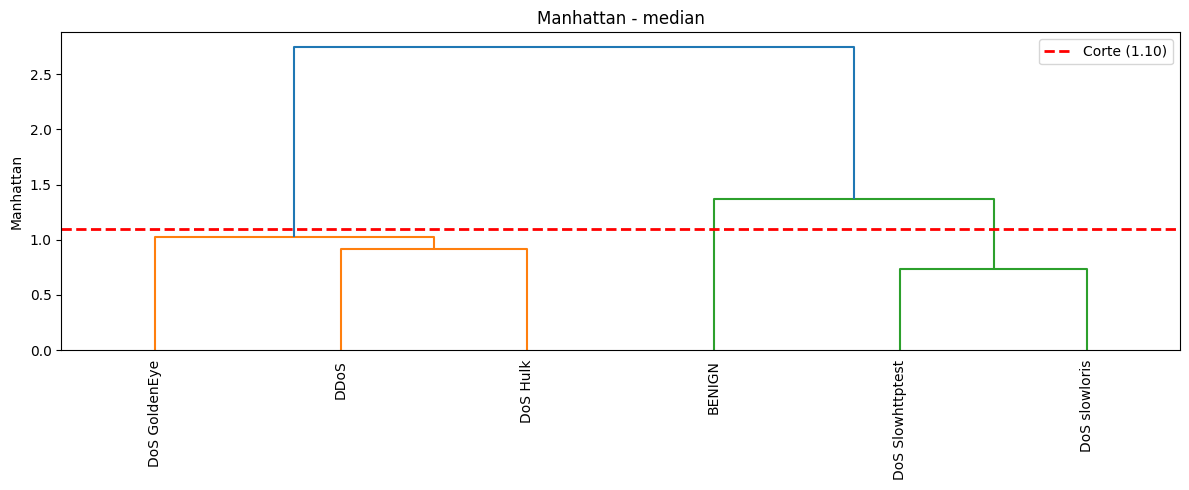

Corte utilizado: 0.42
Métrica: EUCLIDIANA
Ligação: AVERAGE


,Qtd,Ataques,Euclidiana,Assinatura
0,2,"DDoS, DoS Hulk",0.3890,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max"
1,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
2,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"
3,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
4,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"


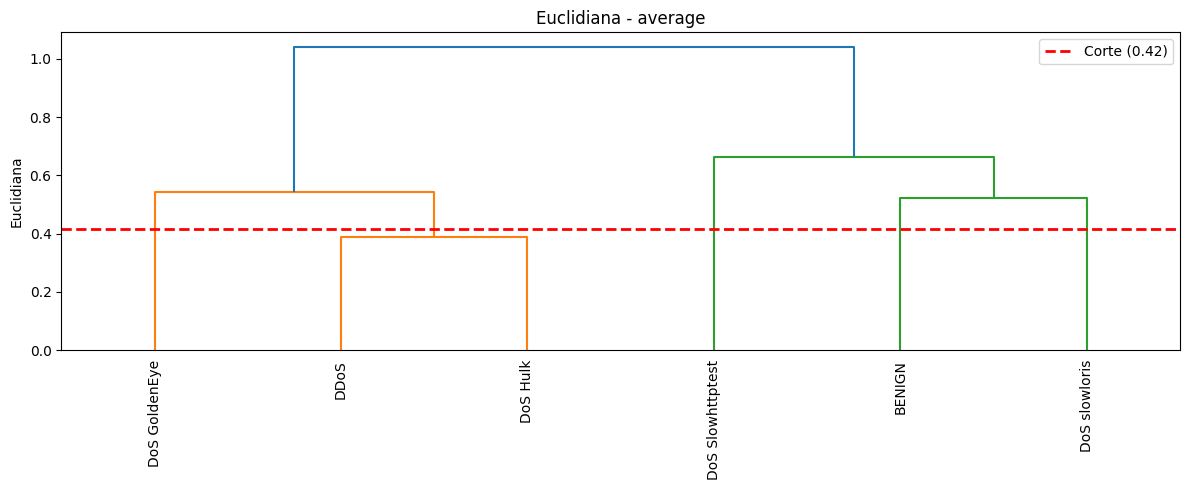

Corte utilizado: 0.51
Métrica: EUCLIDIANA
Ligação: COMPLETE


,Qtd,Ataques,Euclidiana,Assinatura
0,2,"DDoS, DoS Hulk",0.3890,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max"
1,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
2,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"
3,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
4,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"


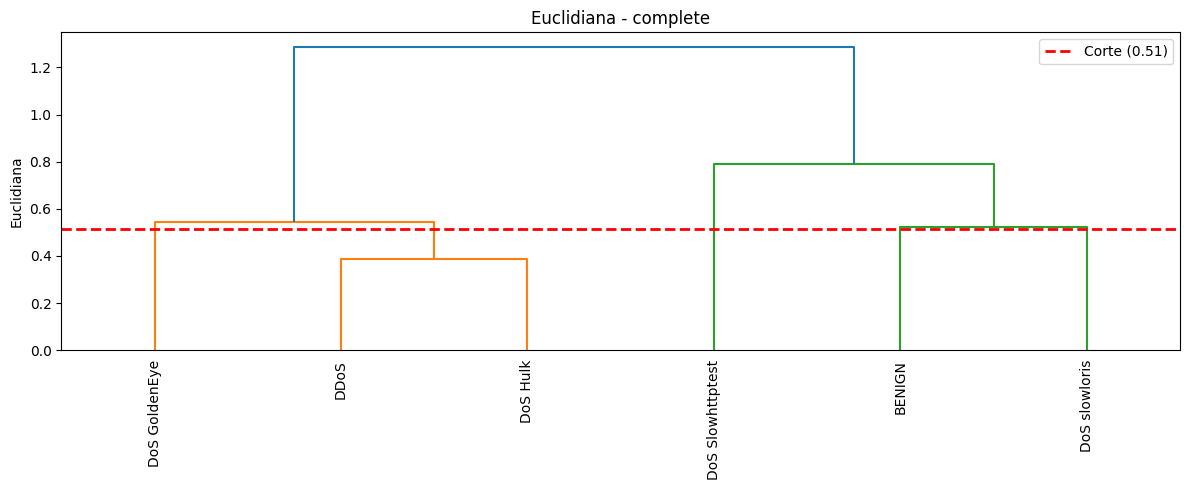

Corte utilizado: 0.37
Métrica: EUCLIDIANA
Ligação: MEDIAN


,Qtd,Ataques,Euclidiana,Assinatura
0,1,DDoS,Único,"Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length"
1,1,DoS Hulk,Único,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
2,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
3,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"
4,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
5,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"


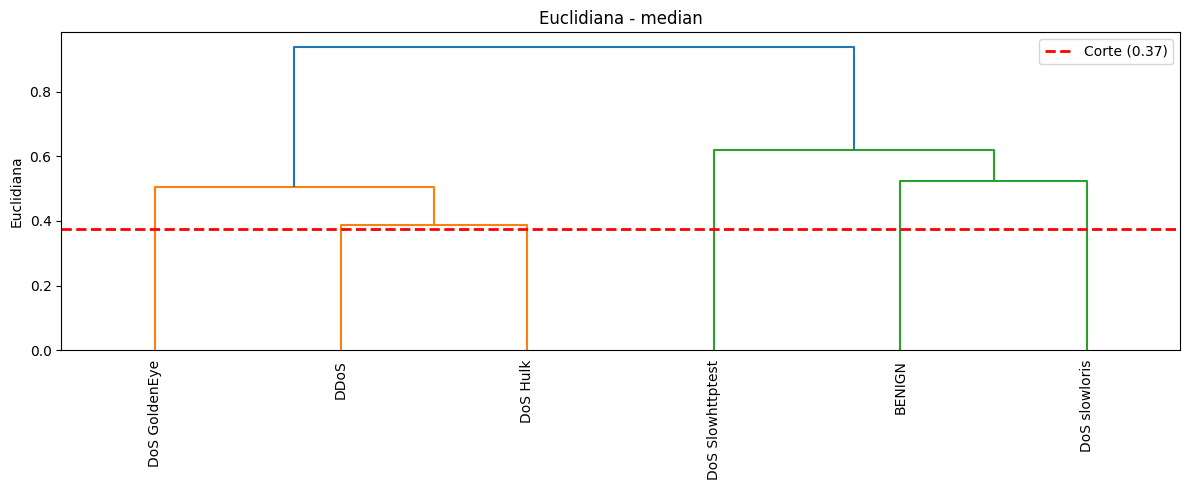

In [26]:
config_metricas = [
    ('Manhattan', 'cityblock'),
    ('Euclidiana', 'euclidean')
]

config_linkage = ['average', 'complete', 'median']

for nome_metrica, str_metrica in config_metricas:
    # Calcula a matriz de distância condensada nativa

    dist_condensada_atual = pdist(df_final_sig, metric=str_metrica)
    # Converte para matriz quadrada para podermos calcular a média interna do grupo depois
    matriz_distancia_full = squareform(dist_condensada_atual)

    for metodo_link in config_linkage:
        # Hierarquia
        Z = linkage(dist_condensada_atual, method=metodo_link)

        # Definição do Corte 
        corte = 0.40 * max(Z[:, 2])
        lbl_corte = f"{corte:.2f}"
        tipo_medida = f"{nome_metrica}"

        # Clusterização
        final_labels = fcluster(Z, t=corte, criterion='distance')

        # Relatório 
        report = []
        for cid in sorted(set(final_labels)):
            membros = df_final_sig.index[final_labels == cid].tolist()
            indices_membros = np.where(final_labels == cid)[0]
            
            if len(membros) > 1:
                # Se tem grupo, calcula a média real
                sub_matriz = matriz_distancia_full[np.ix_(indices_membros, indices_membros)]
                valores_distancia = sub_matriz[np.triu_indices(len(membros), k=1)]
                media_distancia = valores_distancia.mean()
                
                # Formata o valor
                if str_metrica == 'cosine':
                    val_display = 1 - media_distancia # Converte dist volta para similaridade
                    val_str = f"{val_display:.4f}"
                else:
                    val_str = f"{media_distancia:.4f}"
            else:
                # Se for item único, não calculamos média (para não dar 1.0 ou 0.0 enganoso)
                val_str = "Único"

            # Assinatura
            avg_imp = df_final_sig.loc[membros].mean()
            top_feats = avg_imp.nlargest(5).index.tolist()
            
            report.append({
                'Qtd': len(membros),
                'Ataques': ", ".join(membros),
                f'{tipo_medida}': val_str,
                'Assinatura': ", ".join(top_feats)
            })
        
        # Exibir Tabela
        print(f"Corte utilizado: {lbl_corte}")
        print(f"Métrica: {nome_metrica.upper()}")
        print(f"Ligação: {metodo_link.upper()}")
        display(pd.DataFrame(report))

        # Plotar Dendrograma
        plt.figure(figsize=(12, 5))
        dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
        plt.axhline(y=corte, c='r', ls='--', lw=2, label=f'Corte ({corte:.2f})')
        plt.title(f"{nome_metrica} - {metodo_link}")
        plt.ylabel(f"{tipo_medida}")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Criação dos cenários de Teste

## CICDDoS2019

![DNS_DNS](datasets/CICDDoS2019/img/DNS_DNS.png)

![DNS_LDAP](datasets/CICDDoS2019/img/DNS_LDAP.png)

## CIC-IDS-2017

![SLOW_SLOW](datasets/CIC-IDS-2017/img/SLOW_SLOW.png)

![HULK_DDoS](datasets/CIC-IDS-2017/img/HULK_DDoS.png)